# Data Atelier - Prendre en main les méthodes d'explicabilités pour interpréter son modèle de machine learning !

Pour comprendre le fonctionnement des modèles de machine learning, il est proposé de comprendre un modèle appliqué au dataset en open data sur data.gouv : [Baromètre Représentations sociales du changement climatique - data.gouv.fr](https://www.data.gouv.fr/fr/datasets/barometre-representations-sociales-du-changement-climatique/)




## Import des librairies

In [1]:
import pandas as pd
import numpy as np

from category_encoders import OrdinalEncoder
from shapash.explainer.smart_explainer import SmartExplainer
from shapash.explainer.consistency import Consistency
from sklearn.model_selection import train_test_split
import catboost
import lightgbm
from category_encoders import OrdinalEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import metrics
from eurybia import SmartDrift
import pygwalker as pyg

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

## Import du dataset et cleaning

In [3]:
df = pd.read_csv("../data/OpinionWay pour l'ADEME - Baromètre changement climatique - Compilation 2000-2022.csv", 
                       delimiter=';',
                       encoding='Windows-1252')

/home/maitrejinx/anaconda3/envs/eurybia39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning:

Columns (6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,41,42,43,44,45,46,47,48,49,50,51,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,166,169,170,171,172,173,174,176,177,180,182) have mixed types.Specify dtype option on import or set low_memory=False.



In [4]:
df.head(1)

,Vague,S1. genre,S2. âge,S3. Zone géo,Région,Département,S7. Taille commune,S7b. Taille commune,S7c. Taille commune,S6. Situation professionnelle,S5. CSP,q1_1. Enjeu important 1,q1_2. Enjeu important 2,q1_3. Enjeu important 3,q1total. Enjeu Emploi,q1total. Enjeu Sécurité,q1total. Enjeu Education et recherche,q1total. Enjeu Inégalités,q1total. Enjeu Logement,q1total. Enjeu Impôts et taxes,q1total. Enjeu Hausse des prix,q1total. Enjeu Immigration,q1total. Enjeu Environnement/Transition écologique,q1total. Enjeu Déficits publics,q1total. Enjeu Banlieues,q1total. Enjeu Transports,q1total. Enjeu Santé publique,q1total. Enjeu No rep.,q2_1. Problème environnemental 1,q2_2. Problème environnemental 2,q2total. Problème pollution de l'air,q2total. Problème pollution de l'eau,q2total. Problème bruit,q2total. Problème risques nucléaire,q2total. Problème déchets,q2total. Problème dégradation biodiversité,q2total. Problème Effet de serre/ réchauffement climatique,q2total. Problème dégradation des paysages,q2total. Problème aucun,q2total. Problème No rep.,q5. Certitude/hypothèse impact effet de serre,q8. Conséquences changement climatique,q8bis_1. Inquiétude conséquence 1,q8bis_2. Inquiétude conséquence 2,q8bis_total. Inquiétude catastrophe naturelle,q8bis_total. Inquiétude conflits entre Etats,q8bis_total. Inquiétude migrations population,q8bis_total. Inquiétude conflits politiques et sociaux,q8bis_total. Inquiétude développement maladies,q8bis_total. Inquiétude réchauffement températures,q8bis_total. aucun,q8bis_total. No rep.,q9. Causes désordres du climat,q10. Causes anthropiques/naturelles du changement climatique,q11. Solutions changement climatique,q12. Opportunité/ contrainte changement,q13_1. Conditions acceptation changement 1,q13_2. Conditions acceptation changement 2,q13total. Condition changements modérés,q13total. Condition compensation,q13total. Condition équité,q13total. Condition participation,q13total. Condition acceptation dans tous les cas,q13total. Condition No rep.,q14. Médiatisation changement climatique,q14b. Pourquoi souhaitez-vous qu'on en parle plus ?,q15_1. Acteur efficace 1,q15_2. Acteur efficace 2,q15total. instances internationales,q15total. Etats,q15total. collectivités locales,q15total. entreprises,q15total. associations,q15total. Chacun d'entre nous,q15total. Personne,q15total. No rep.,q15b_1. Acteur actif 1,q15b_2. Acteur actif 2,q15btotal. instances internationales,q15btotal. Etats,q15btotal. collectivités locales,q15btotal. entreprises,q15btotal. associations,q15btotal. Chacun d'entre nous,q15btotal. Personne,q15btotal. No rep.,q16. Optimisme limitation changement climatique,q18_i1. Causes GES activités industrielles,q18_i2. Causes GES transports,q18_i3. Causes GES bâtiments,q18_i4. Causes GES agriculture,"q18_i5. Causes GES centrales de production d'électricité au gaz, charbon ou fuel",q18_i6. Causes GES traitement des déchets,q18_i7. Causes GES destruction des forêts,q18_i8. Causes GES centrales nucléaires,q18_i9. Causes GES activité volcanique,q18_i10. Causes GES bombes aérosols,q18_i11. Causes GES numérique,q19_1. Action efficace réduction GES 1,q19_2. Action efficace réduction GES 2,q19total. Action efficace Achat voiture consommant moins,"q19total. Action efficace covoiturage, autopartage",q19total. Action efficace modes alternatifs voiture,q19total. Action efficace isolation logement,"q19total. Action efficace chauffage, chauffe-eau performant",q19total. Action efficace Appareils ménagers consommant moins,q19total. Action efficace EnR pour son logement,q19total. Action efficace consommer moins ou produits ayant moins d’impact,q19total. Action efficace réduire trier ses déchets,q19total. Action efficace télétravail,q19total. Action efficace No rep.,splitq20,q20_i1. Action individuelle Tri déchets,q20_i2. Actin individuelle Eteindre appareils en veille,q20_i3. Actin individuelle Transports en commun,q20_i4. Actin individuelle Baisse température logement,q20_i5. Actin individuelle Acheter légumes de s

In [5]:
# création d'une variable sur une note moyenne des actions individuelles que le sondé est prêt à faire
notes_mapping = {
    '...vous le faites déjà': 4,
    '...vous pourriez le faire assez facilement': 3,
    '...vous pourriez le faire mais difficilement': 2,
    '...vous ne pouvez pas le faire': 1
}

def calculer_moyenne(row):
    notes = [notes_mapping[val] for val in row if val != 'No rep.']
    return sum(notes) / len(notes) if notes else 0

df_q20 = df.filter(like='q20', axis=1).replace({'nan': 'No rep.', np.nan: 'No rep.'})

colonnes_action_individuelle = df_q20.filter(like='q20').drop(columns=['splitq20'])

df_q20['moyenne_action_individuelle'] = colonnes_action_individuelle.apply(calculer_moyenne, axis=1)

df_q20['moyenne_action_individuelle'].round().value_counts()

3.0    13819
0.0     7407
4.0     4949
2.0     1589
1.0      104
Name: moyenne_action_individuelle, dtype: int64

In [6]:
df['q21_i1. Mesures Baisse vitesse autoroute'].value_counts()

Pas vraiment souhaitable    4930
Pas du tout souhaitable     4895
Assez souhaitable           4712
Très souhaitable            2887
No rep.                      407
Name: q21_i1. Mesures Baisse vitesse autoroute, dtype: int64

In [7]:
# création d'une variable cible sur le taux de mesures que le sondé souhaite Très ou Assez souhaitable
notes_mapping = {
    'Très souhaitable': 4,
    'Assez souhaitable': 3,
    'Pas vraiment souhaitable': 2,
    'Pas du tout souhaitable': 1
}

# Filtrer les colonnes qui commencent par "q21"
q21_columns = [col for col in df.columns if col.startswith('q21')]

df_q21 = df.filter(like='q21', axis=1).replace({'nan': 'No rep.', np.nan: 'No rep.'})

# Initialiser une nouvelle colonne dans le DataFrame pour stocker les taux
df_q21['taux_mesures_souhaitable'] = 0.0

# Parcourir les lignes et calculer le taux pour chaque individu
for index, row in df_q21.iterrows():
    total_cols_answered = sum(row[col] != "No rep." for col in q21_columns)
    if total_cols_answered > 0:
        desirable_count = sum(row[col] in ['Très souhaitable', 'Assez souhaitable'] for col in q21_columns)
        rate = desirable_count / total_cols_answered
        df_q21.at[index, 'taux_mesures_souhaitable'] = rate

In [8]:
df = pd.concat([df, df_q20[['moyenne_action_individuelle']], df_q21[['taux_mesures_souhaitable']]], axis=1)

In [9]:
# Dictionnaire de renommage des colonnes pour avoir un nom plus simple et court
columns_to_rename = {'S1. genre' : 'genre',
                      'S2. âge' : 'tranche_age',
                      'S3. Zone géo' : 'zone_geo',
                      'Région' : 'region',
                      'Département' : 'departement',
                      'S7b. Taille commune' : 'taille_commune',
                      'S6. Situation professionnelle' : 'situation_pro',
                      'S5. CSP' : 'csp',
                      'q5. Certitude/hypothèse impact effet de serre' : 'impact_effet_de_serre',
                      'q9. Causes désordres du climat' : 'cause_desordre',
                      's11. Désordre climatique subi' : "changement_subi",
                      'q10. Causes anthropiques/naturelles du changement climatique' : 'cause_changement_climatique',
                      'q11. Solutions changement climatique' : 'solutions',
                      'q18_i1. Causes GES activités industrielles' : 'causes_ges_industries', 
                      'q18_i2. Causes GES transports' : 'causes_ges_transports',
                      'q18_i3. Causes GES bâtiments' : 'causes_ges_batiments',
                      'q18_i4. Causes GES agriculture' : 'causes_ges_agriculture',
                      "q18_i5. Causes GES centrales de production d'électricité au gaz, charbon ou fuel"  : 'causes_ges_energie',
                      'q18_i6. Causes GES traitement des déchets' : 'causes_ges_dechets',
                      'q18_i7. Causes GES destruction des forêts' : 'causes_ges_forets',
                      'q18_i8. Causes GES centrales nucléaires': 'causes_ges_nucleaires',
                      'q18_i9. Causes GES activité volcanique' : 'causes_ges_volcans',
                      'q18_i10. Causes GES bombes aérosols' : 'causes_ges_aerosols',
                      'q18_i11. Causes GES numérique' : 'causes_ges_numeriques',
                      's13. Nb membres foyer' :'nb_membres_foyer',
                      's15. Diplôme' :'diplome', 
                      's17. Type habitat' : 'type_habitat',
                      's18. Statut locataire/propriétaire' : 'locataire_proprietaire',
                      's22. Mode de transport' : 'mode_transport',
                      's23. Partis politiques' : 'partis_politiques', 
                      's24. Echiquier politique' : 'echiquier_politiques',
                      's25. Sympathie mouvements écologistes' : 'sympathie_ecologie',
                      'q23. Véracité scientifique' : 'veracite_scientifique',
                      'q14. Médiatisation changement climatique' : 'mediatisation',
                      'q8. Conséquences changement climatique' : 'futures_consequences',
                      'q16. Optimisme limitation changement climatique' : 'limitation_changement',
                      'q13total. Condition changements modérés' : 'changements_moderes',
                      "q15btotal. associations" : "associations_acteurs",
                      "q15total. collectivités locales" : "collectivites_acteurs",
                      'q21_i1. Mesures Baisse vitesse autoroute' : 'baisse_vitesse_autoroute',
                      'q21_i10. Mesures Favoriser véhicules peu polluants' : 'favoriser_mobilite_douce',
                      'q21_i11. Mesures Menu restauration collective' : 'mesure_restauration'
                      }

In [10]:
df.rename(columns=columns_to_rename, inplace=True)

In [11]:
# Sélection de features à conserver pour le modèle
features = ['Vague',
            'genre',
            'tranche_age',
            #'zone_geo',
            'region',
            #'departement',
            'taille_commune',
            'situation_pro',
            #'csp',
            'impact_effet_de_serre',
            'cause_desordre',
            'cause_changement_climatique',
            'solutions',
            'causes_ges_industries', 
            'causes_ges_transports',
            'causes_ges_batiments',
            'causes_ges_agriculture',
            'causes_ges_energie',            
            'causes_ges_forets',
            'causes_ges_nucleaires',
            'causes_ges_volcans',
            'causes_ges_aerosols',
            #'causes_ges_numeriques',
            'nb_membres_foyer',
            'diplome', 
            'type_habitat',
            'locataire_proprietaire',
            'mode_transport',
            'echiquier_politiques', 
            'sympathie_ecologie',
            'changement_subi',
            'veracite_scientifique',
            'mediatisation',
            'futures_consequences',
            'limitation_changement',
            #'changements_moderes',
            #'associations_acteurs',
            #'collectivites_acteurs',
            'moyenne_action_individuelle',
            'taux_mesures_souhaitable',
                      ]

In [12]:
#suppressions des lignes avec trop de valeurs vides et la cible "solutions" non répondu
print(df.shape)
df_reduit = df[features].copy()
df_reduit['number_of_NaNs'] = df_reduit.isnull().sum(axis=1)
df_reduit = df_reduit[df_reduit["number_of_NaNs"]<8]                      
df_reduit = df_reduit[df_reduit["taux_mesures_souhaitable"] !=0]
print(df_reduit.shape)

(27868, 185)
(17331, 34)


In [13]:
df_reduit.isna().sum()

Vague                             0
genre                             0
tranche_age                       0
region                            0
taille_commune                    0
situation_pro                     0
impact_effet_de_serre             0
cause_desordre                    0
cause_changement_climatique       0
solutions                         0
causes_ges_industries             0
causes_ges_transports             0
causes_ges_batiments              0
causes_ges_agriculture            0
causes_ges_energie                0
causes_ges_forets                 0
causes_ges_nucleaires             0
causes_ges_volcans                0
causes_ges_aerosols               0
nb_membres_foyer                  0
diplome                           0
type_habitat                      0
locataire_proprietaire            0
mode_transport                    0
echiquier_politiques           3883
sympathie_ecologie                0
changement_subi                3883
veracite_scientifique       

In [14]:
#nous remplaçons les Nan pour les colonnes sélectionnées
df_reduit.fillna("No rep.", inplace=True)

### Renommage des modalités 
Nous renommons les modalités de certaines colonnes pour un meilleur affichage

In [15]:
df_reduit.loc[df_reduit['cause_changement_climatique'] == 'Le réchauffement de la planète est causé par les activités humaines', 'cause_changement_climatique'] = 'activites_humaines'
df_reduit.loc[df_reduit['cause_changement_climatique'] == "Il s'agit uniquement d'un phénomène naturel qui a toujours existé", 'cause_changement_climatique'] = 'phenomene_naturel'

df_reduit.loc[df_reduit['impact_effet_de_serre'] == '...ou bien une certitude pour la plupart des scientifiques ?', 'impact_effet_de_serre'] = 'certitude_scientifique'
df_reduit.loc[df_reduit['impact_effet_de_serre'] == "...une hypothèse sur laquelle les scientifiques ne sont pas tous d'accord ?", 'impact_effet_de_serre'] = 'hypothese_non_certaine'

df_reduit.loc[df_reduit['sympathie_ecologie'] == '...assez de sympathie ?', 'sympathie_ecologie'] = 'assez'
df_reduit.loc[df_reduit['sympathie_ecologie'] == "...peu de sympathie ?", 'sympathie_ecologie'] = 'peu'
df_reduit.loc[df_reduit['sympathie_ecologie'] == "...beaucoup de sympathie ?", 'sympathie_ecologie'] = 'beaucoup'
df_reduit.loc[df_reduit['sympathie_ecologie'] == "...pas de sympathie ?", 'sympathie_ecologie'] = 'pas'

df_reduit.loc[df_reduit['cause_desordre'] == 'Les désordres du climat et leurs conséquences (tels que les canicules, les tempêtes, les sécheresses et les inondati', 'cause_desordre'] = 'certitudes_causes'
df_reduit.loc[df_reduit['cause_desordre'] == "Aujourd'hui, personne ne peut dire avec certitude les vraies raisons des désordres du climat", 'cause_desordre'] = 'pas_certitude'

df_reduit.loc[df_reduit['veracite_scientifique'] == 'Les scientifiques qui étudient les évolutions du climat évaluent correctement les risques du changement climatique', 'veracite_scientifique'] = 'evalue_correctement'
df_reduit.loc[df_reduit['veracite_scientifique'] == "Les scientifiques qui étudient les évolutions du climat exagèrent les risques du changement climatique", 'veracite_scientifique'] = 'scientifique_exagere'

# Cette variable est la cible du modèle
df_reduit.loc[df_reduit['solutions'] == 'Il faudra modifier de façon importante nos modes de vie pour limiter le changement climatique', 'solutions'] = 'changer'
df_reduit.loc[df_reduit['solutions'].str.contains("le changement climatique est inévitable") , 'solutions'] = 'inevitable'
df_reduit.loc[df_reduit['solutions'] == "C'est aux Etats de rechercher un accord au niveau mondial pour limiter le changement climatique", 'solutions'] = 'entre_etats'
df_reduit.loc[df_reduit['solutions'] == "Le progrès technique permettra de trouver des solutions pour limiter le changement climatique", 'solutions'] = 'progres'

In [16]:
df_reduit['veracite_scientifique'].value_counts()

evalue_correctement     12417
scientifique_exagere     4719
No rep.                   195
Name: veracite_scientifique, dtype: int64

### Proposition de l'outils Pygwalker pour analyser les distributions des données

In [17]:
#walker = pyg.walk(df_reduit, env="Jupyter")

## Modélisation

In [18]:
y = df_reduit["taux_mesures_souhaitable"]
X = df_reduit.drop(["taux_mesures_souhaitable","number_of_NaNs","Vague"], axis=1)

In [19]:
#Conversion des variables catégorielles en numérique
features_cat = [e for e in features if e not in ("taux_mesures_souhaitable", "moyenne_action_individuelle", "Vague")]

encoder = OrdinalEncoder(
    cols=features_cat,
    handle_unknown='ignore',
    return_df=True).fit(X)

X=encoder.transform(X)

In [20]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, train_size=0.75, random_state=1
)

model = catboost.CatBoostRegressor(max_depth=5)
model.fit(Xtrain, ytrain, verbose=False)

In [21]:
prediction = model.predict(Xtest)

mean_squared_error(ytest, prediction)


0.04020960417082458

<hr>
<h1>Interprétabilité avec Shapash</h1>
<hr>

In [22]:
#Init Shapash
xpl = SmartExplainer(model=model,preprocessing=encoder) 

In [23]:
# Compilation de Shapash
xpl.compile(
    x=Xtest,    
    y_target = ytest,
    additional_data=df_reduit.loc[Xtest.index, :][["Vague"]],
)

In [24]:
#Lancement de la webapp
app=xpl.run_app(port=8088)

INFO:root:Your Shapash application run on http://maitrejinx-Latitude-E5570:8088/


Dash is running on http://0.0.0.0:8088/



INFO:root:Use the method .kill() to down your app.
INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8088/



 * Serving Flask app "shapash.webapp.smart_app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [25]:
app.kill()

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/maitrejinx/anaconda3/envs/eurybia39/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/home/maitrejinx/anaconda3/envs/eurybia39/lib/python3.9/site-packages/shapash/utils/threading.py", line 29, in __run
    self.__run_backup()
  File "/home/maitrejinx/anaconda3/envs/eurybia39/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/home/maitrejinx/anaconda3/envs/eurybia39/lib/python3.9/site-packages/shapash/explainer/smart_explainer.py", line 1079, in <lambda>
    

Questions ?


les principaux éléments qui expliquent la classification en "changer" et "ne_pas_changer" 

les principaux éléments qui expliquent les erreurs de prédictions

les profils où la prédiction est à la limite

des anomalies 

des analyses par sous population


<hr>
<h1>Indicateurs de confiance dans les explicabilités</h1>
<hr>

3 indicateurs sont proposés dans Shapash pour mesurer la confiance que l'on peut en avoir dans son explicabilité

## Consistency

Cette métrique permet de mesurer la distance moyenne entre 2 explicabilités

### Comparaison pour 2 modèles différents
Nous pouvons mesurer la consistance entre 2 explicabilités qui proviennent de 2 modèles différents (exemples : xgboost, lightgbm)

A noter qu'il est possible également de mesurer la consistance entre 2 explicabilités compilés avec 2 méthodes différentes (exemple : shap & lime)

### Modèle lightgbm pour comparaison avec catboost

In [26]:
model_lgb = lightgbm.LGBMRegressor()
model_lgb.fit(Xtrain, ytrain)

target=lambda: self.smartapp.app.run_server(debug=False, host=host, port=port))
  File "/home/maitrejinx/anaconda3/envs/eurybia39/lib/python3.9/site-packages/dash/dash.py", line 2078, in run_server
    self.server.run(host=host, port=port, debug=debug, **flask_run_options)
  File "/home/maitrejinx/anaconda3/envs/eurybia39/lib/python3.9/site-packages/flask/app.py", line 990, in run
    run_simple(host, port, self, **options)
  File "/home/maitrejinx/anaconda3/envs/eurybia39/lib/python3.9/site-packages/werkzeug/serving.py", line 1010, in run_simple
    inner()
  File "/home/maitrejinx/anaconda3/envs/eurybia39/lib/python3.9/site-packages/werkzeug/serving.py", line 950, in inner
    srv = make_server(
  File "/home/maitrejinx/anaconda3/envs/eurybia39/lib/python3.9/site-packages/werkzeug/serving.py", line 782, in make_server
    return ThreadedWSGIServer(
  File "/home/maitrejinx/anaconda3/envs/eurybia39/lib/python3.9/site-packages/werkzeug/serving.py", line 688, in __init__
    super().__i

LGBMRegressor()

In [27]:
prediction_lgb = model_lgb.predict(Xtest)

mean_squared_error(ytest, prediction_lgb)

0.0401553990496185

In [28]:
xpl_lgb = SmartExplainer(model=model_lgb,preprocessing=encoder)
xpl_lgb.compile(
    x=Xtest,    
    y_target = ytest
)

### Compilation de la méthode Consistency

In [29]:
contributions = {"catboost_shap": xpl.contributions, "lightgbm_shap": xpl_lgb.contributions}

In [30]:
cns = Consistency()
cns.compile(x=Xtest.reset_index(drop=True), # Dataset for which we need explanations
            contributions=contributions
            )

/home/maitrejinx/anaconda3/envs/eurybia39/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



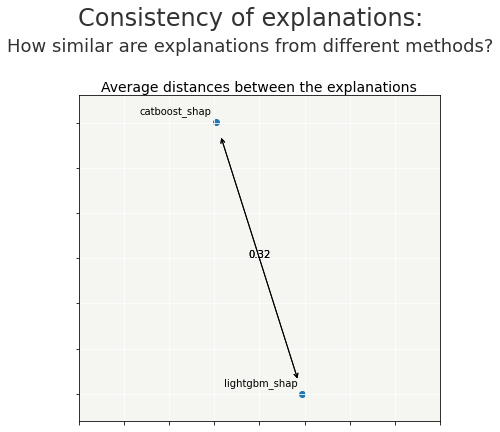

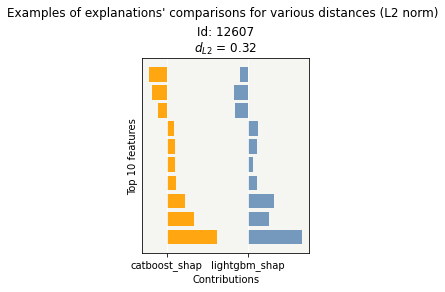

In [31]:
cns.consistency_plot(max_features=10)


In [32]:
#Cette figure représente l'écart de distributions entre les explicabilités par feature
cns.pairwise_consistency_plot(methods=["catboost_shap", "lightgbm_shap"], max_features=5)

In [33]:
#Cette figure permet de voir les interactions des contributions entre 2 features
#xpl.plot.top_interactions_plot(nb_top_interactions=5)

## Compacity

Cette métrique permet de visualiser le nombre de features nécessaires pour expliquer un % de la prédiction. 

In [34]:
xpl.plot.compacity_plot()

## Stability

Cette métrique permet de visualiser la stabilité de l'explicabilité en comparant les explicabilités entre proches voisins

In [35]:
#Pour un individu
xpl.plot.local_neighbors_plot(index=xpl.x_init.iloc[0].name)

In [36]:
#Au global
xpl.plot.stability_plot()

In [37]:
#Au global
xpl.plot.stability_plot(max_features=5, distribution="boxplot")

Computed values from previous call are used


# Stabilité des données

L'idée est de voir si les données sont similaires entre les périodes de sondages et si la période d'apprentissage est adaptée et que les données sont similaires

In [38]:
df_periode1 = df_reduit[df_reduit['Vague'].isin(['Vague 11','Vague 12','Vague 13','Vague 14','Vague 15','Vague 16','Vague 17'])].drop(["Vague","taux_mesures_souhaitable","number_of_NaNs"], axis=1)
df_periode2 = df_reduit[~df_reduit['Vague'].isin(['Vague 11','Vague 12','Vague 13','Vague 14','Vague 15','Vague 16','Vague 17'])].drop(["Vague","taux_mesures_souhaitable","number_of_NaNs"], axis=1)

In [39]:
sd = SmartDrift(
    df_current=df_periode1,
    df_baseline=df_periode2,
    deployed_model=model,  # Optional: put in perspective result with importance on deployed model
    encoding=encoder,  # Optional: if deployed_model and encoder to use this model
    dataset_names={
        "df_current": "Vague 18 - 23",
        "df_baseline": "Vague 11 - 17",
    },  # Optional: Names for outputs
)

In [40]:
sd.compile()

KeyboardInterrupt: 

In [ ]:
sd.generate_report(
    output_file="stabilite_vague.html",
    title_story="Stabilité Vague"
)

TypeError: type NoneType doesn't define __round__ method

In [ ]:
df_reduit.drop('Vague', 1).isna().groupby(df.Vague, sort=False).sum().reset_index()

/tmp/ipykernel_101217/1263096022.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



,Vague,genre,tranche_age,region,taille_commune,situation_pro,impact_effet_de_serre,cause_desordre,cause_changement_climatique,solutions,causes_ges_industries,causes_ges_transports,causes_ges_batiments,causes_ges_agriculture,causes_ges_energie,causes_ges_forets,causes_ges_nucleaires,causes_ges_volcans,causes_ges_aerosols,nb_membres_foyer,diplome,type_habitat,locataire_proprietaire,mode_transport,echiquier_politiques,sympathie_ecologie,changement_subi,veracite_scientifique,mediatisation,futures_consequences,limitation_changement,moyenne_action_individuelle,moyenne_mesures_souhaitables,number_of_NaNs
0,Vague 11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Vague 12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Vague 13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Vague 14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Vague 15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Vague 16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Vague 17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Vague 18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Vague 19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Vague 20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_reduit.echiquier_politiques.value_counts()

No rep.                    4359
Ni à gauche ni à droite    3788
A droite                   2768
A gauche                   2762
Au centre                  2475
Très à droite               959
Très à gauche               531
Name: echiquier_politiques, dtype: int64

<hr>
<h1>Génération du rapport Shapash</h1>
<hr>

Le rapport permet d'avoir une version figée de l'explicabilité. Il peut avoir plusieurs objectifs : à des fins de traçabilité, d'archivage, d'audit,....



In [ ]:
xpl.generate_report(
    output_file='report_barometre_changement_climatique.html',
    project_info_file='./project_info_barometre.yml',
    x_train=Xtrain,
    y_train=ytrain,
    y_test=ytest,
    title_story="Barometre Changement Climatique",
    title_description="""Ce rapport contient la description et l'explicabilité d'un modèle de prédiction
    de la solution envisagée par des sondés face aux problématique du changement climatique""",
    metrics=[{'name': 'AUC', 'path': 'sklearn.metrics.roc_auc_score'}]
)

Executing: 100%|██████████| 15/15 [00:29<00:00,  1.94s/cell]


# Application sur le sondage framaform

import chardet

# Read the file
with open("../data/Sondage_TP_barometre.csv", 'rb') as f:
    result = chardet.detect(f.read())

In [41]:
#df_framaform = pd.read_csv("../data/Sondage_TP_barometre.tsv", sep='\t')

df_framaform = pd.read_csv("../data/Sondage_TP_barometre.csv", encoding = 'Windows-1252', sep='\t')


In [42]:
df_framaform.head()

,Vague,S1. genre,S2. âge,Région,S7b. Taille commune,s15. Diplôme,S6. Situation professionnelle,s17. Type habitat,s13. Nb membres foyer,s18. Statut locataire/propriétaire,q5. Certitude/hypothèse impact effet de serre,q9. Causes désordres du climat,q10. Causes anthropiques/naturelles du changement climatique,q11. Solutions changement climatique,q18_i1. Causes GES activités industrielles,q18_i2. Causes GES transports,q18_i3. Causes GES bâtiments,q18_i4. Causes GES agriculture,"q18_i5. Causes GES centrales de production d'électricité au gaz, charbon ou fuel",q18_i6. Causes GES traitement des déchets,q18_i7. Causes GES destruction des forêts,q18_i8. Causes GES centrales nucléaires,q18_i9. Causes GES activité volcanique,q18_i10. Causes GES bombes aérosols,s22. Mode de transport,s24. Echiquier politique,s25. Sympathie mouvements écologistes,s11. Désordre climatique subi,q23. Véracité scientifique,q14. Médiatisation changement climatique,q8. Conséquences changement climatique,q16. Optimisme limitation changement climatique,q20_i1. Action individuelle Tri déchets,q20_i2. Actin individuelle Eteindre appareils en veille,q20_i3. Actin individuelle Transports en commun,q20_i4. Actin individuelle Baisse température logement,q20_i5. Actin individuelle Acheter légumes de saison,q20_i6. Actin individuelle Limiter consommation viande,q20_i7. Actin individuelle Se déplacer en vélo ou à pied,q20_i8. Actin individuelle Covoiturage ou de l'auto-partage,q20_i9. Actin individuelle Produits avec peu d'emballage,q20_i10. Action individuelle choix Ecolabels,q20_i11. Action individuelle Consommer moins,"q20_i12. Action individuelle Couper chauffage, chauffe-eau",q20_i13. Action individuelle Pas prendre l'avion pour ses loisirs,q20_i14. Action individuelle Produits locaux,q20_i15. Action individuelle Achats vêtements seconde main,q20_i16. Action individuelle Choisir pour mon épargne une banque et/ou des placements financiers qui respectent …,q21_i1. Mesures Baisse vitesse autoroute,q21_i2. Mesures Taxe transport aérien,q21_i3. Mesures Obligation rénovation,q21_i4. Mesures Compteurs communicants,q21_i5. Mesures Prix acheminement produits,q21_i6. Mesures Taxe carbone,q21_i7. Mesures EnR,q21_i8. Mesures Densifier les villes,q21_i9. Mesures Taxe véhicules émetteurs,q21_i10. Mesures Favoriser véhicules peu polluants,q21_i11. Mesures Menu restauration collective,q21_i13. Mesures Supprimer dates de péremption,q21_i14. Mesures Interdire publicité,identifiant
0,TP,Un homme,25-34 ans,Aquitaine - Limousin - Poitou - Charente,Dans une ville de 20.000 à moins de 100.000 ha...,"2EME, 3EME CYCLE UNIVERSITAIRE OU GRANDES ECOLES",...exercez actuellement une profession,Une maison individuelle,1 personne,Propriétaire (y compris copropriétaire et accé...,...ou bien une certitude pour la plupart des s...,Les désordres du climat et de leurs conséquenc...,Le réchauffement de la planète est causé par l...,Il faudra modifier de façon importante nos mod...,Beaucoup,Beaucoup,Beaucoup,Beaucoup,Beaucoup,Assez,Assez,Assez,Peu,Peu,En vélo ou à pied,Très à gauche,...beaucoup de sympathie ?,"Oui, parfois",Les scientifiques qui étudient les évolutions ...,On n'en parle pas assez,Les conditions de vie deviendront extrêmement ...,"Non, certainement pas",...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous le faites déjà,...vous pourriez le faire assez facilement,...vous pourriez le faire assez facilement,...vous le faites déjà,...vous pourriez le faire assez facilement,...vous pourriez le faire assez facilement,Très souhaitable,Très souhaitable,Assez souhaitable,Assez souhaitable,Très souhaitable,Assez souhaitable,Assez souhaitable,Pas vraiment souhaitable,Très souhaitable,Très souhaitable,Très souhaitable,Assez souhaitable,Très souhaitable,xr4979
1,TP,Un homme,25-34 ans,Ile de France,Dans une ville de 20.000

In [43]:
# création d'une variable sur une note moyenne des actions individuelles que le sondé est prêt à faire
notes_mapping = {
    '...vous le faites déjà': 4,
    '...vous pourriez le faire assez facilement': 3,
    '...vous pourriez le faire mais difficilement': 2,
    '...vous ne pouvez pas le faire': 1
}

def calculer_moyenne(row):
    notes = [notes_mapping[val] for val in row if val != 'No rep.']
    return sum(notes) / len(notes) if notes else 0

df_framaform_q20 = df_framaform.filter(like='q20', axis=1).replace({'nan': 'No rep.', np.nan: 'No rep.'})

colonnes_action_individuelle = df_framaform_q20.filter(like='q20')

df_framaform_q20['moyenne_action_individuelle'] = colonnes_action_individuelle.apply(calculer_moyenne, axis=1)

df_framaform_q20['moyenne_action_individuelle'].round().value_counts()

4.0    1
3.0    1
Name: moyenne_action_individuelle, dtype: int64

In [44]:
# création d'une variable cible sur le taux de mesures que le sondé souhaite Très ou Assez souhaitable
notes_mapping = {
    'Très souhaitable': 4,
    'Assez souhaitable': 3,
    'Pas vraiment souhaitable': 2,
    'Pas du tout souhaitable': 1
}

# Filtrer les colonnes qui commencent par "q21"
q21_columns = [col for col in df_framaform.columns if col.startswith('q21')]

df_framaform_q21 = df_framaform.filter(like='q21', axis=1).replace({'nan': 'No rep.', np.nan: 'No rep.'})

# Initialiser une nouvelle colonne dans le DataFrame pour stocker les taux
df_framaform_q21['taux_mesures_souhaitable'] = 0.0

# Parcourir les lignes et calculer le taux pour chaque individu
for index, row in df_framaform_q21.iterrows():
    total_cols_answered = sum(row[col] != "No rep." for col in q21_columns)
    if total_cols_answered > 0:
        desirable_count = sum(row[col] in ['Très souhaitable', 'Assez souhaitable'] for col in q21_columns)
        rate = desirable_count / total_cols_answered
        df_framaform_q21.at[index, 'taux_mesures_souhaitable'] = rate

In [45]:
df_framaform = pd.concat([df_framaform, df_framaform_q20[['moyenne_action_individuelle']], df_framaform_q21['taux_mesures_souhaitable']], axis=1)

In [46]:
df_framaform.rename(columns=columns_to_rename, inplace=True)

In [47]:
df_framaform_reduit = df_framaform[features].copy()

In [48]:
df_framaform_reduit.fillna("No rep.", inplace=True)

In [49]:
df_framaform_reduit.loc[df_framaform_reduit['cause_changement_climatique'] == 'Le réchauffement de la planète est causé par les activités humaines', 'cause_changement_climatique'] = 'activites_humaines'
df_framaform_reduit.loc[df_framaform_reduit['cause_changement_climatique'] == "Il s'agit uniquement d'un phénomène naturel qui a toujours existé", 'cause_changement_climatique'] = 'phenomene_naturel'

df_framaform_reduit.loc[df_framaform_reduit['impact_effet_de_serre'] == '...ou bien une certitude pour la plupart des scientifiques ?', 'impact_effet_de_serre'] = 'certitude_scientifique'
df_framaform_reduit.loc[df_framaform_reduit['impact_effet_de_serre'] == "...une hypothèse sur laquelle les scientifiques ne sont pas tous d'accord ?", 'impact_effet_de_serre'] = 'hypothese_non_certaine'

df_framaform_reduit.loc[df_framaform_reduit['sympathie_ecologie'] == '...assez de sympathie ?', 'sympathie_ecologie'] = 'assez'
df_framaform_reduit.loc[df_framaform_reduit['sympathie_ecologie'] == "...peu de sympathie ?", 'sympathie_ecologie'] = 'peu'
df_framaform_reduit.loc[df_framaform_reduit['sympathie_ecologie'] == "...beaucoup de sympathie ?", 'sympathie_ecologie'] = 'beaucoup'
df_framaform_reduit.loc[df_framaform_reduit['sympathie_ecologie'] == "...pas de sympathie ?", 'sympathie_ecologie'] = 'pas'

df_framaform_reduit.loc[df_framaform_reduit['cause_desordre'].str.contains('Les désordres du climat'), 'cause_desordre'] = 'certitudes_causes'
df_framaform_reduit.loc[df_framaform_reduit['cause_desordre'].str.contains("Aujourd'hui, personne ne peut dire avec certitude les vraies raisons des désordres du climat"), 'cause_desordre'] = 'pas_certitude'

df_framaform_reduit.loc[df_framaform_reduit['veracite_scientifique'].str.contains('évaluent correctement les risques du changement climatique'), 'veracite_scientifique'] = 'evalue_correctement'
df_framaform_reduit.loc[df_framaform_reduit['veracite_scientifique'] == "Les scientifiques qui étudient les évolutions du climat exagèrent les risques du changement climatique", 'veracite_scientifique'] = 'scientifique_exagere'

# Cette variable est la cible du modèle
df_framaform_reduit.loc[df_framaform_reduit['solutions'] == 'Il faudra modifier de façon importante nos modes de vie pour limiter le changement climatique', 'solutions'] = 'changer'
df_framaform_reduit.loc[df_framaform_reduit['solutions'].str.contains("le changement climatique est inévitable") , 'solutions'] = 'inevitable'
df_framaform_reduit.loc[df_framaform_reduit['solutions'] == "C'est aux Etats de rechercher un accord au niveau mondial pour limiter le changement climatique", 'solutions'] = 'entre_etats'
df_framaform_reduit.loc[df_framaform_reduit['solutions'] == "Le progrès technique permettra de trouver des solutions pour limiter le changement climatique", 'solutions'] = 'progres'

In [50]:
df_framaform_reduit.head()

,Vague,genre,tranche_age,region,taille_commune,situation_pro,impact_effet_de_serre,cause_desordre,cause_changement_climatique,solutions,causes_ges_industries,causes_ges_transports,causes_ges_batiments,causes_ges_agriculture,causes_ges_energie,causes_ges_forets,causes_ges_nucleaires,causes_ges_volcans,causes_ges_aerosols,nb_membres_foyer,diplome,type_habitat,locataire_proprietaire,mode_transport,echiquier_politiques,sympathie_ecologie,changement_subi,veracite_scientifique,mediatisation,futures_consequences,limitation_changement,moyenne_action_individuelle,taux_mesures_souhaitable
0,TP,Un homme,25-34 ans,Aquitaine - Limousin - Poitou - Charente,Dans une ville de 20.000 à moins de 100.000 ha...,...exercez actuellement une profession,certitude_scientifique,certitudes_causes,activites_humaines,changer,Beaucoup,Beaucoup,Beaucoup,Beaucoup,Beaucoup,Assez,Assez,Peu,Peu,1 personne,"2EME, 3EME CYCLE UNIVERSITAIRE OU GRANDES ECOLES",Une maison individuelle,Propriétaire (y compris copropriétaire et accé...,En vélo ou à pied,Très à gauche,beaucoup,"Oui, parfois",evalue_correctement,On n'en parle pas assez,Les conditions de vie deviendront extrêmement ...,"Non, certainement pas",3.75,0.923077
1,TP,Un homme,25-34 ans,Ile de France,Dans une ville de 20.000 à moins de 100.000 ha...,...exercez actuellement une profession,certitude_scientifique,certitudes_causes,activites_humaines,entre_etats,Beaucoup,Assez,Beaucoup,Beaucoup,Beaucoup,Beaucoup,Assez,Assez,Beaucoup,3 personnes,"2EME, 3EME CYCLE UNIVERSITAIRE OU GRANDES ECOLES",Un appartement,Locataire,En transports en commun urbains (dont métro),No rep.,beaucoup,"Non, rarement",evalue_correctement,On n'en parle pas assez,Les conditions de vie deviendront extrêmement ...,"Non, certainement pas",3.00,0.846154


In [51]:
y_framaform = df_framaform_reduit["taux_mesures_souhaitable"]
X_framaform = df_framaform_reduit.drop(["taux_mesures_souhaitable","Vague"], axis=1)

In [52]:
X_framaform=encoder.transform(X_framaform)

In [59]:
prediction_framaform = model.predict(X_framaform)

mean_squared_error(y_framaform, prediction_framaform)

0.0022124973031188346

In [60]:
xpl_framaform = SmartExplainer(model=model,preprocessing=encoder) 

In [61]:
#Si pas assez de données framaform, concat avec Xtest
X_frama = pd.concat([X_framaform, Xtest.head(1000)])
y_frama = pd.concat([y_framaform, ytest.head(1000)])




In [62]:
xpl_framaform.compile(
    x=X_frama,    
    y_target = y_frama,
    additional_data=pd.concat([df_framaform_reduit[["Vague"]],df_reduit.loc[Xtest.head(1000).index, :][["Vague"]]]),
)

In [63]:
X_framaform.head()

,genre,tranche_age,region,taille_commune,situation_pro,impact_effet_de_serre,cause_desordre,cause_changement_climatique,solutions,causes_ges_industries,causes_ges_transports,causes_ges_batiments,causes_ges_agriculture,causes_ges_energie,causes_ges_forets,causes_ges_nucleaires,causes_ges_volcans,causes_ges_aerosols,nb_membres_foyer,diplome,type_habitat,locataire_proprietaire,mode_transport,echiquier_politiques,sympathie_ecologie,changement_subi,veracite_scientifique,mediatisation,futures_consequences,limitation_changement,moyenne_action_individuelle
0,2,1,9,2,1,3,1,1,1,2,1,2,4,1,3,3,1,3,4,4,2,2,3,5,1,4,2,3,1,5,3.75
1,2,1,5,2,1,3,1,1,3,2,2,2,4,1,1,3,2,1,3,4,1,1,4,1,1,2,2,3,1,5,3.00


In [ ]:
app_framaform=xpl_framaform.run_app(port=8078)

INFO:root:Your Shapash application run on http://maitrejinx-Latitude-E5570:8078/


Dash is running on http://0.0.0.0:8078/



INFO:root:Use the method .kill() to down your app.


Dash is running on http://0.0.0.0:8078/

Dash is running on http://0.0.0.0:8078/

Dash is running on http://0.0.0.0:8078/



INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8078/



 * Serving Flask app "shapash.webapp.smart_app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://192.168.1.11:8078/ (Press CTRL+C to quit)


INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:52:44] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:52:45] "GET /assets/material-icons.css?m=1697552065.1605535 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:52:45] "GET /assets/style.css?m=1697552065.1685536 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:52:45] "GET /_dash-component-suites/dash/deps/react@16.v2_3_1m1650918725.14.0.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:52:45] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_3_1m1650918725.12.1.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:52:45] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_3_1m1650918725.14.0.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:52:45] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_3_1m1650918725.7.2.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:52:45] "GET /_dash-component-suites/dash_daq/dash_daq.v0_5_0m

In [66]:
xpl_framaform.plot.compare_plot(index=[df_framaform_reduit.index[0], df_framaform_reduit.index[1]])

INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:54:52] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:54:52] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:55:15] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:55:16] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:55:18] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:55:18] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:55:19] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:55:19] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:55:20] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Nov/2023 11:55:21] "POST /_dash-update-component HTTP/1.1" 200 -
